In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trade_data
from passivbot import load_settings
from backtester import *

In [3]:
plt.rcParams['figure.figsize'] = [21, 13]
pd.set_option('precision', 10)

In [4]:
settings = load_settings('default')
settings

{'quot': 'BTC',
 'coins_long': ['ADA',
  'ATOM',
  'BAT',
  'BCH',
  'BNB',
  'DASH',
  'EOS',
  'ETC',
  'ETH',
  'IOST',
  'IOTA',
  'LINK',
  'LTC',
  'MATIC',
  'NEO',
  'ONT',
  'QTUM',
  'RVN',
  'TRX',
  'VET',
  'XLM',
  'XMR',
  'XRP',
  'XTZ',
  'ZEC'],
 'coins_shrt': ['ADA',
  'ATOM',
  'BAT',
  'BCH',
  'DASH',
  'EOS',
  'ETC',
  'ETH',
  'IOST',
  'IOTA',
  'LINK',
  'LTC',
  'MATIC',
  'NEO',
  'ONT',
  'QTUM',
  'RVN',
  'TRX',
  'VET',
  'XLM',
  'XMR',
  'XRP',
  'XTZ',
  'ZEC'],
 'do_not_borrow': ['BNB'],
 'profit_pct': 0.0025,
 'account_equity_pct_per_trade': 0.0006,
 'account_equity_pct_per_hour': 0.0045,
 'hours_rolling_small_trade_window': 1.0,
 'bnb_buffer': 50.3,
 'max_memory_span_days': 30,
 'snapshot_timestamp_millis': 0,
 'ema_spans_minutes': [15, 25, 40, 64, 102, 164, 263, 421, 675, 1080],
 'user': 'default'}

In [5]:
fee = 1 - 0.0675 * 0.01 # vip1


# modify settings here


#settings['profit_pct'] = 0.0025

#settings['account_equity_pct_per_trade'] = 0.0006

#settings['account_equity_pct_per_hour'] = 0.0045

#settings['max_memory_span_days'] = 30

#settings['ema_spans_minutes'] = [15, 25, 40, 64, 102, 164, 263, 421, 675, 1080]
print(settings['account_equity_pct_per_trade'] * 60)

0.036


In [6]:
symbols = [f'{c}/BTC' for c in settings['coins_long']]
symbols = sorted(symbols)
n_days = 180
symbols

['ADA/BTC',
 'ATOM/BTC',
 'BAT/BTC',
 'BCH/BTC',
 'BNB/BTC',
 'DASH/BTC',
 'EOS/BTC',
 'ETC/BTC',
 'ETH/BTC',
 'IOST/BTC',
 'IOTA/BTC',
 'LINK/BTC',
 'LTC/BTC',
 'MATIC/BTC',
 'NEO/BTC',
 'ONT/BTC',
 'QTUM/BTC',
 'RVN/BTC',
 'TRX/BTC',
 'VET/BTC',
 'XLM/BTC',
 'XMR/BTC',
 'XRP/BTC',
 'XTZ/BTC',
 'ZEC/BTC']

In [7]:
# set no_download to True to load faster if already downloaded ohlcvs
high_low_means = load_hlms(symbols, n_days, no_download=False)

fetched 1m ohlcvs for ADA/BTC 2020-06-29T21:59:00
fetched 1m ohlcvs for ADA/BTC 2020-06-27T14:50:00
fetched 1m ohlcvs for ADA/BTC 2020-04-24T13:50:00
fetched 1m ohlcvs for ADA/BTC 2020-03-03T19:50:00
fetched 1m ohlcvs for ADA/BTC 2020-02-19T01:50:00
fetched 1m ohlcvs for ADA/BTC 2020-02-08T11:20:00
fetched 1m ohlcvs for ADA/BTC 2019-12-31T08:20:00
2020-06-30T14:38:26  2019-12.csv already present, merging... 
2020-06-30T14:38:27  2020-02.csv already present, merging... 
2020-06-30T14:38:28  2020-03.csv already present, merging... 
2020-06-30T14:38:28  2020-04.csv already present, merging... 
2020-06-30T14:38:29  2020-06.csv already present, merging... 
fetched 1m ohlcvs for ATOM/BTC 2020-06-29T21:59:00
fetched 1m ohlcvs for ATOM/BTC 2020-06-27T14:50:00
fetched 1m ohlcvs for ATOM/BTC 2020-04-24T13:50:00
fetched 1m ohlcvs for ATOM/BTC 2020-03-03T19:50:00
fetched 1m ohlcvs for ATOM/BTC 2020-02-19T01:50:00
fetched 1m ohlcvs for ATOM/BTC 2020-02-08T11:20:00
fetched 1m ohlcvs for ATOM/BTC 201

fetched 1m ohlcvs for LTC/BTC 2020-02-08T11:20:00
fetched 1m ohlcvs for LTC/BTC 2020-01-01T12:21:00
2020-06-30T14:40:30  2020-01.csv already present, merging... 
2020-06-30T14:40:31  2020-02.csv already present, merging... 
2020-06-30T14:40:32  2020-03.csv already present, merging... 
2020-06-30T14:40:33  2020-04.csv already present, merging... 
2020-06-30T14:40:34  2020-06.csv already present, merging... 
fetched 1m ohlcvs for MATIC/BTC 2020-06-29T22:01:00
fetched 1m ohlcvs for MATIC/BTC 2020-06-27T14:50:00
fetched 1m ohlcvs for MATIC/BTC 2020-04-24T13:50:00
fetched 1m ohlcvs for MATIC/BTC 2020-03-03T19:50:00
fetched 1m ohlcvs for MATIC/BTC 2020-02-19T01:50:00
fetched 1m ohlcvs for MATIC/BTC 2020-02-08T11:20:00
fetched 1m ohlcvs for MATIC/BTC 2019-12-31T08:20:00
2020-06-30T14:40:40  2019-12.csv already present, merging... 
2020-06-30T14:40:41  2020-02.csv already present, merging... 
2020-06-30T14:40:42  2020-03.csv already present, merging... 
2020-06-30T14:40:43  2020-04.csv already

2020-06-30T14:42:35  2020-04.csv already present, merging... 
2020-06-30T14:42:36  2020-06.csv already present, merging... 


In [8]:
df = add_emas(high_low_means, settings['ema_spans_minutes'])
print(f'n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:2f}')

n_days 179.996528


In [9]:
balance_list, lentr, sentr, lexit, sexit, lexitpl, sexitpl = backtest(df, settings)

100.00% acc equity quot: 4.646169  avg daily gain: 1.008570

In [10]:
# balances are in terms of quot
bldf = pd.DataFrame(balance_list).set_index('timestamp')

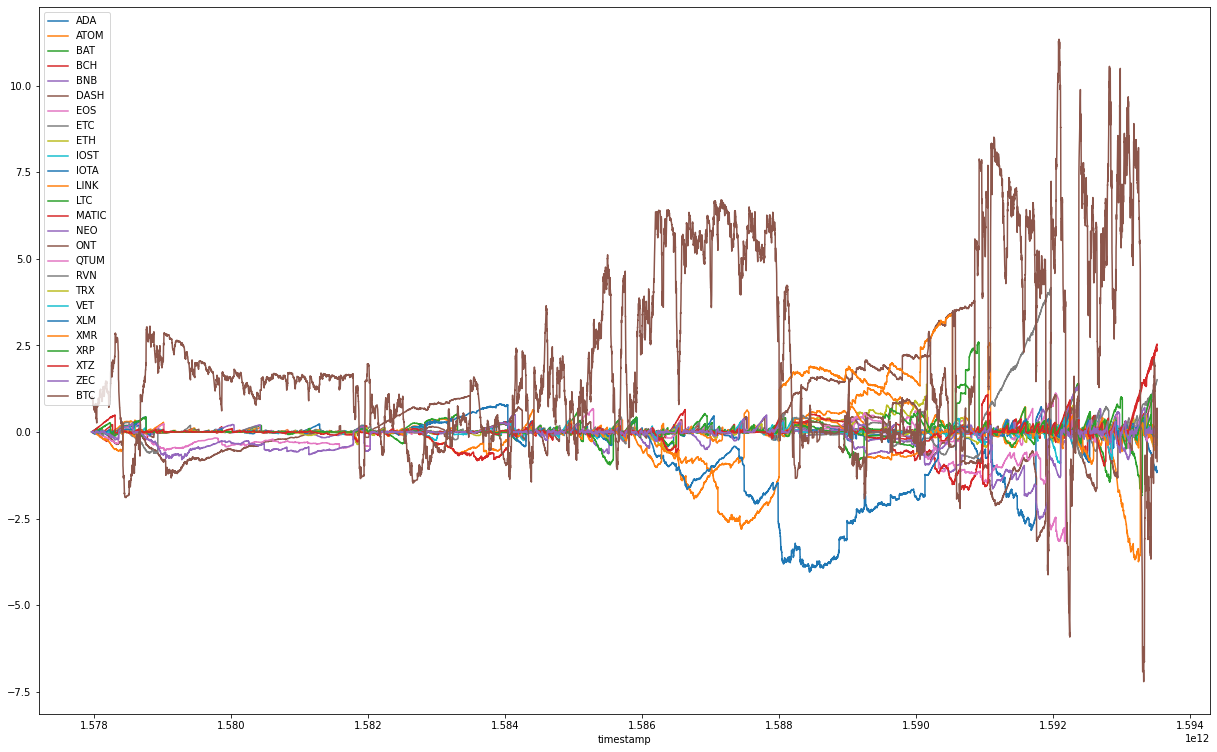

In [11]:
bldf.drop(['acc_equity_quot', 'acc_debt_quot'], axis=1).iloc[::10].plot()

average daily gain 1.00857032


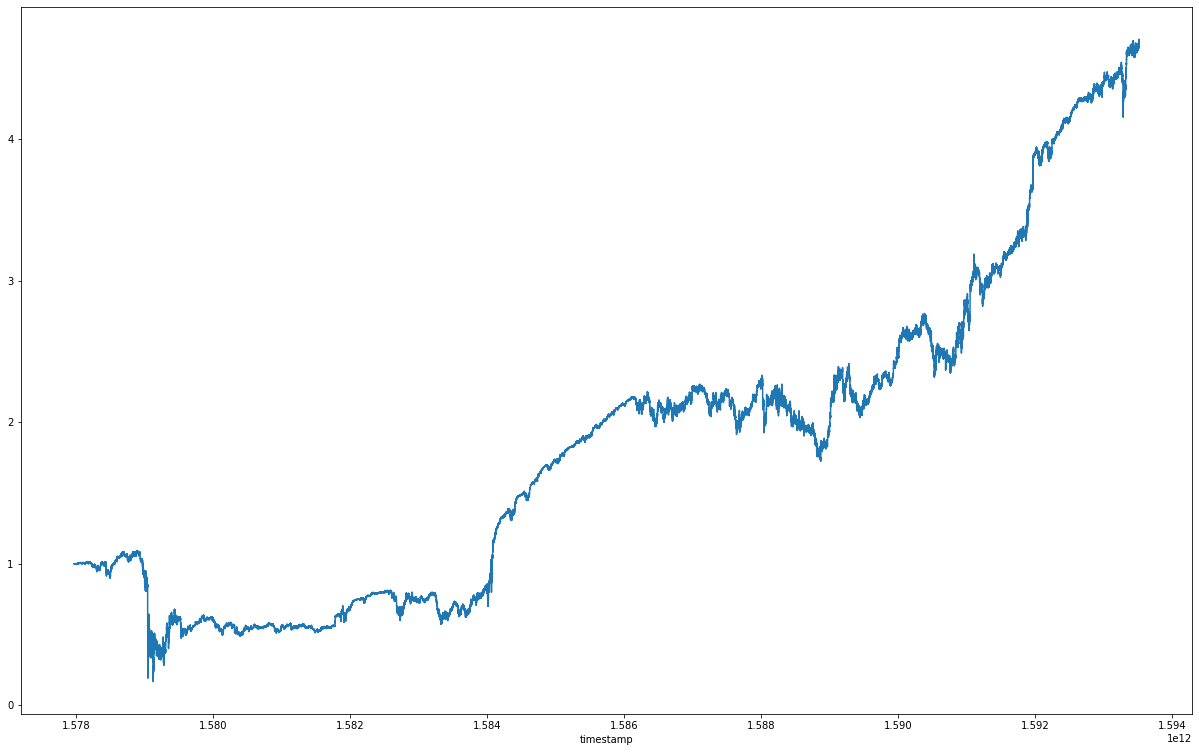

In [12]:
start_equity = bldf.acc_equity_quot.iloc[0]
end_equity = bldf.acc_equity_quot.iloc[-1]
n_days = (bldf.index[-1] - bldf.index[0]) / 1000 / 60 / 60 / 24
avg_daily_gain = (end_equity / start_equity)**(1 / n_days)
print('average daily gain', round(avg_daily_gain, 8))
bldf.acc_equity_quot.plot()

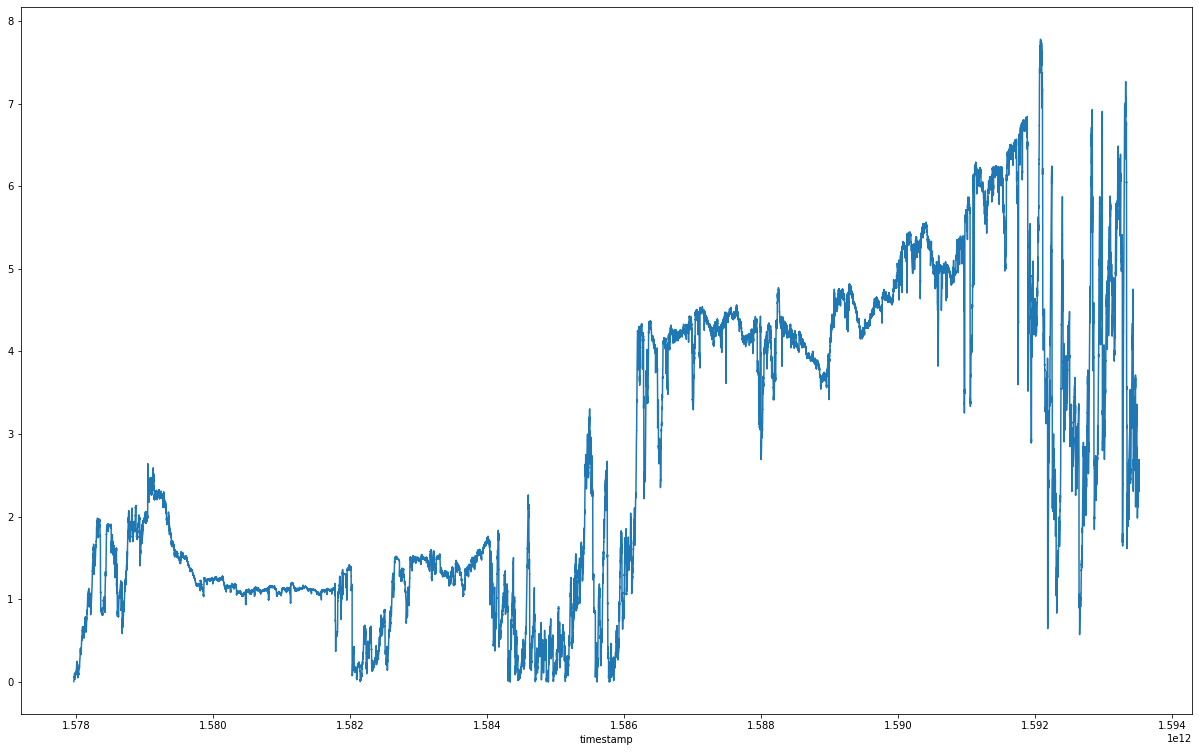

In [13]:
bldf.acc_debt_quot.plot()

In [14]:
sum_vol = 0.0
for s in symbols:
    s_ = s.replace('/', '_')
    vol = sum([e['price'] * e['amount'] for e in lentr[s_]])
    vol += sum([e['price'] * e['amount'] for e in sentr[s_]])
    vol += sum([e['price'] * e['amount'] for e in lexit[s_]])
    vol += sum([e['price'] * e['amount'] for e in sexit[s_]])
    sum_vol += vol
    print(s, vol)
print('approx monthly vol', sum_vol / n_days * 30)

ADA/BTC 77.94973967981467
ATOM/BTC 72.25399321233093
BAT/BTC 71.53909495384467
BCH/BTC 68.14776643173033
BNB/BTC 71.51731506939181
DASH/BTC 71.87408763673476
EOS/BTC 68.57510484735839
ETC/BTC 68.80459662006193
ETH/BTC 68.95199614425326
IOST/BTC 79.78910184383398
IOTA/BTC 65.90368839614936
LINK/BTC 75.66097130722494
LTC/BTC 66.25997838677625
MATIC/BTC 76.90998415908967
NEO/BTC 67.98817867701622
ONT/BTC 73.53922716860254
QTUM/BTC 64.66851001484515
RVN/BTC 79.61892004864242
TRX/BTC 79.41593157613076
VET/BTC 79.73744247247329
XLM/BTC 70.81037340126832
XMR/BTC 68.011828384214
XRP/BTC 75.61694802359824
XTZ/BTC 67.88418137236648
ZEC/BTC 68.0610308265803
approx monthly vol 299.9207839513385


In [15]:
# bag status at end
sorted([(round(e[1], 6), e[0]) for e in dict(bldf.iloc[-1]).items() if 'acc' not in e[0]])

[(-1.117982, 'ADA'),
 (-0.88338, 'BTC'),
 (-0.230579, 'TRX'),
 (-0.166446, 'XLM'),
 (-0.073639, 'BNB'),
 (-0.059807, 'RVN'),
 (-0.004702, 'VET'),
 (-0.000334, 'XMR'),
 (0.007691, 'IOTA'),
 (0.008435, 'LINK'),
 (0.009549, 'ATOM'),
 (0.01617, 'ETH'),
 (0.019034, 'XRP'),
 (0.020522, 'DASH'),
 (0.0223, 'IOST'),
 (0.022973, 'NEO'),
 (0.032516, 'BAT'),
 (0.056061, 'QTUM'),
 (0.067657, 'ZEC'),
 (0.070325, 'BCH'),
 (0.074801, 'ONT'),
 (0.08367, 'EOS'),
 (0.200083, 'LTC'),
 (1.513044, 'ETC'),
 (2.428348, 'XTZ'),
 (2.529857, 'MATIC')]

In [16]:
sum_p = 0.0
for s in map(lambda x: x.replace('/', '_'), symbols):
    # all buys
    abdf = pd.DataFrame(sorted(lentr[s] + sexit[s], key=lambda x: x['timestamp'])).set_index('timestamp')

    # all sels
    asdf = pd.DataFrame(sorted(sentr[s] + lexit[s], key=lambda x: x['timestamp'])).set_index('timestamp')
    buy_cost = (abdf.price * abdf.amount).sum()
    sel_cost = (asdf.price * asdf.amount).sum()
    sum_cost = buy_cost + sel_cost
    buy_vwap = buy_cost / abdf.amount.sum()
    sel_vwap = sel_cost / asdf.amount.sum()
    diff = (sel_vwap / buy_vwap) * fee**2
    approx_profit = buy_cost * (diff * fee**2 - 1)
    print(s, f'buy vol: {buy_cost:.4f} sel vol: {sel_cost:.4f} sum vol: {sum_cost:.4f}')
    print(s, f'buy vwap: {buy_vwap:.10f} sel vwap: {sel_vwap:.10f} diff: {(sel_vwap / buy_vwap):.6f}')
    print(s, f'approx profit: {approx_profit:.6f}')
    print()
    sum_p += approx_profit
print('approx sum profit', sum_p)

ADA_BTC buy vol: 38.3278 sel vol: 39.6219 sum vol: 77.9497
ADA_BTC buy vwap: 0.0000061600 sel vwap: 0.0000062481 diff: 1.014299
ADA_BTC approx profit: 0.443201

ATOM_BTC buy vol: 36.0811 sel vol: 36.1729 sum vol: 72.2540
ATOM_BTC buy vwap: 0.0003184000 sel vwap: 0.0003195191 diff: 1.003515
ATOM_BTC approx profit: 0.029159

BAT_BTC buy vol: 35.6985 sel vol: 35.8406 sum vol: 71.5391
BAT_BTC buy vwap: 0.0000238824 sel vwap: 0.0000240123 diff: 1.005439
BAT_BTC approx profit: 0.097336

BCH_BTC buy vol: 34.0555 sel vol: 34.0922 sum vol: 68.1478
BCH_BTC buy vwap: 0.0291531123 sel vwap: 0.0292768555 diff: 1.004245
BCH_BTC approx profit: 0.052305

BNB_BTC buy vol: 35.6727 sel vol: 35.8447 sum vol: 71.5173
BNB_BTC buy vwap: 0.0018733867 sel vwap: 0.0018793811 diff: 1.003200
BNB_BTC approx profit: 0.017617

DASH_BTC buy vol: 36.2254 sel vol: 35.6487 sum vol: 71.8741
DASH_BTC buy vwap: 0.0088063419 sel vwap: 0.0086778048 diff: 0.985404
DASH_BTC approx profit: -0.625029

EOS_BTC buy vol: 34.3265 se

In [17]:
# analyze particular symbol
s = 'XTZ_BTC'

In [18]:
ledf = pd.DataFrame(lentr[s]).set_index('timestamp')
sedf = pd.DataFrame(sentr[s]).set_index('timestamp')
lexitdf = pd.DataFrame(lexit[s]).set_index('timestamp')
sexitdf = pd.DataFrame(sexit[s]).set_index('timestamp')
lexitpdf = pd.DataFrame(lexitpl[s]).set_index('timestamp')
sexitpdf = pd.DataFrame(sexitpl[s]).set_index('timestamp')

In [19]:
# longest bag durations
d = 1000 * 60 * 60 * 24
for e in sorted(np.diff(lexitdf.index / d))[-10:]:
    print('long bag duration days', round(e, 2))
print()
for e in sorted(np.diff(sexitdf.index / d))[-10:]:
    print('shrt bag duration days', round(e, 2))

long bag duration days 1.72
long bag duration days 1.79
long bag duration days 1.96
long bag duration days 2.01
long bag duration days 2.17
long bag duration days 2.36
long bag duration days 2.4
long bag duration days 2.98
long bag duration days 3.89
long bag duration days 25.26

shrt bag duration days 1.97
shrt bag duration days 2.0
shrt bag duration days 2.18
shrt bag duration days 2.2
shrt bag duration days 2.89
shrt bag duration days 3.19
shrt bag duration days 4.6
shrt bag duration days 4.83
shrt bag duration days 8.12
shrt bag duration days 13.8


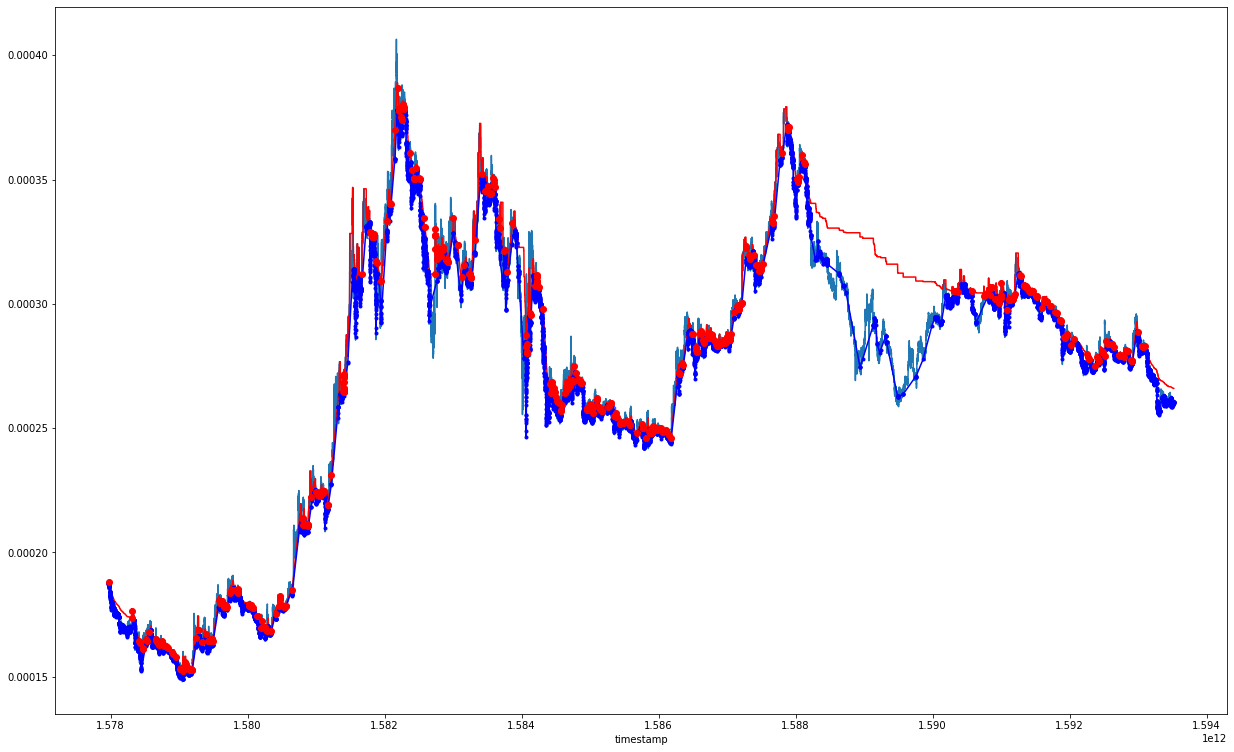

In [20]:
high_low_means[s + '_mean'].plot()
lexitpdf.price.plot(style='r-')
ledf.price.plot(style='b.-')
lexitdf.price.plot(style='ro')

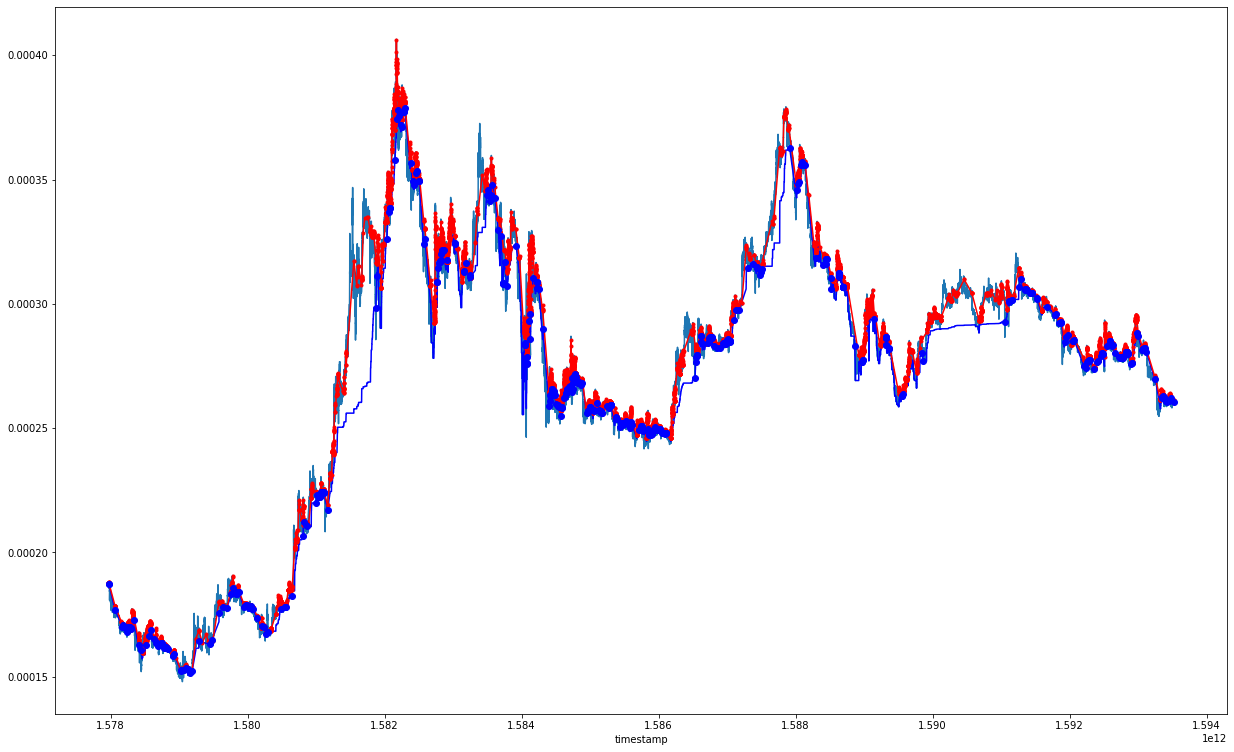

In [21]:
high_low_means[s + '_mean'].plot()
sexitpdf.price.plot(style='b-')
sedf.price.plot(style='r.-')
sexitdf.price.plot(style='bo')